In [1]:
import functools
from matplotlib import pyplot as plt, ticker
import os
import pandas as pd
import numpy as np

import bcnetwork as bc

## Explicacion gráfica de las variables de resto

In [2]:
resources_path = '../thesis/presentacion/images/'

get_resource_path = functools.partial(os.path.join, resources_path)

In [3]:
"""
Copied from
scripts/functions.py
scripts/docresources.py
"""

DEFAULT_M = .4

def get_logit_rate(m):    
    """    
    Logit function rate varies with m    
    so that edges are close to 0 and 1    
    """        
    return 3 / (1 - m)    
     
     
def linear(p, m=DEFAULT_M):    
    """    
    Linear version of f    
    """       
    return (p - 1) / (m - 1)    
     
     
def inv_logit(p, m=DEFAULT_M):    
    """    
    Logit version of f    
    """    
    rate = get_logit_rate(m)    
    p = p - (1 + m) / 2    
    p *= rate * 2    
     
    return 1 / (1 + np.exp(p))


def draw_rest_example():
    m = 0.4
    breakpoint_count = 3
    demand = 750
    base_shortet_path = 1000
    domain = np.linspace(m, 1, 30)

    fig, ax = plt.subplots(figsize=(5.1,4))

    func = functools.partial(inv_logit, m=m)

    ax.plot(    
        domain * base_shortet_path,    
        bc.model_utils.normalize(func(domain)) * demand,    
        color=bc.colors.sky_blue, label='Real',    
    )    
    middle_p = 375
    middle_q = 700
    breakpoints = [(0.0, 1), (middle_p / 750, middle_q / 1000), (1, m)]
    breakpoints.reverse()    
    ys, xs = zip(*breakpoints)    
    transfers = np.array(ys) * demand
    improvements = np.array(xs) * base_shortet_path

    absolute_breakpoints = list(zip(transfers, improvements))

    for i, point in enumerate(absolute_breakpoints):
        y, x = point
        label = None

        if i == 0:
            prev_x = (m - 0.05) * base_shortet_path
        else:
            prev_x = absolute_breakpoints[i - 1][1]

        if i == len(absolute_breakpoints) - 1:
            label = 'Repr.'

        ax.plot([prev_x, x], [y, y], color=bc.colors.gray_dark, label=label)

    # Draw random point functional value
    w = 530.0
    r_from = w
    r_to = middle_q - 5
    ax.hlines(
        0.0, r_from, r_to, color=bc.colors.orange,
        linestyle='dotted', label='Variable r')
    arrow_params = dict(
        color=bc.colors.orange,
        length_includes_head=True,
        head_width=20,
        head_length=10,
    )
    ax.arrow(
        r_from, 0, - 2, 0,
        **arrow_params,
    )
    ax.arrow(
        r_to, 0, 2, 0,
        **arrow_params,
    )

    ax.tick_params(axis='y', which='both', labelrotation=45)
    num_formatter = ticker.FormatStrFormatter('%.2f')
    ax.xaxis.set_major_formatter(num_formatter)

    transfers.sort()
    y_values = transfers
    ax.set_yticks(transfers)
    ax.set_yticklabels([format(d, '.1f') for d in transfers])
    x_values = sorted(list(improvements) + [w])
    ax.set_xticks(x_values)
    ax.set_xticklabels([
        format(d, '.1f') if d != w else 'W' for d in x_values])

    ax.set_xlim(right=800)
    ax.set_ylim(top=500)
    ax.legend(loc=(0.2, 0.2))
    
    fig.savefig(get_resource_path('r_visualization.png'), dpi=300, transparent=True)

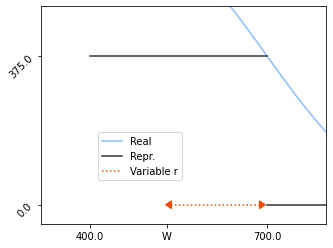

In [4]:
draw_rest_example()

## Montevideo

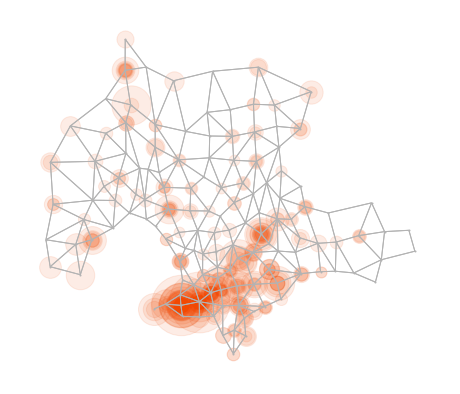

In [5]:
montevideo_path = functools.partial(os.path.join, '../instances/montevideo/')
model = bc.model.Model(
    nodes_file=montevideo_path('nodes.csv'),
    arcs_file=montevideo_path('arcs.csv'),
    odpairs_file=montevideo_path('demands.csv'),
)

fig, ax = plt.subplots(figsize=(8, 7))
bc.draw.draw_demand_weight(ax, model, circle_factor=50, destination_color=None, show_top=300)
bc.draw.draw(model, ax=ax, odpairs=False, node_size=1, with_labels=False)

fig.savefig(get_resource_path('mdeo_demand_topN.png'), dpi=300, bbox_inches='tight', transparent=True)

### Flows and cycling network for one of them

In [6]:
def read_instances(data_path):
    instances = []

    for entry in os.scandir(data_path):
        if 'solution' in entry.path or not entry.path.endswith('pkl'):
            continue

        dirname, basename = os.path.dirname(entry.path), os.path.basename(entry.path)
        solution_path = os.path.join(dirname,'solution_' + basename)
        if not os.path.exists(solution_path):
            continue

        model = bc.model.Model.load(entry.path)
        solution = bc.solution.Solution.load(solution_path)

        instances.append((model, solution))
    
    return instances

In [7]:
instances = read_instances('../data/montevideo_v4')

In [8]:
model, solution = next(filter(lambda x: '0.4' in x[0].name, instances))

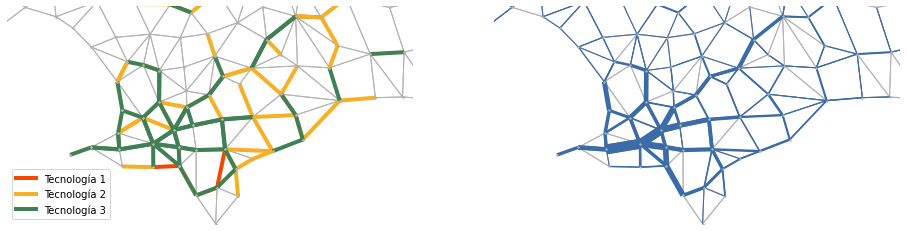

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))

kwargs = dict(
    with_labels=False,
    node_size=1,
    odpairs=False,
    flow_arrows=False,
    infrastructure_arrows=False,
    flow_legend=False,
    infrastructures_legend=True,
    flow_scale_factor=10,
    infrastructure_scale_factor=4,
)
bc.draw.draw(model, solution=solution, ax=axs[0], infrastructures=True, flows=False, **kwargs)
bc.draw.draw(model, solution=solution, ax=axs[1], infrastructures=False, flows=True, **kwargs)

pos = [model.graph.nodes[n]['pos'] for n in model.graph.nodes()]
x, y = zip(*pos)
min_y = min(y)
dy = max(y) - min_y
min_x = min(x)
dx = max(x) - min_x

for ax in axs:
    ax.set_ylim(min_y + dy * 0.0, min_y + dy * 0.45)
    ax.set_xlim(min_x + dx * 0.2, min_x + dx * 0.8)
    
fig.savefig(get_resource_path('mdeo_0.4_results.png'), dpi=300, bbox_inches='tight', transparent=True)

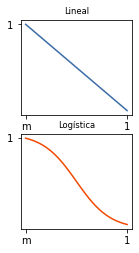

In [10]:
## Funciones de transferencia de demanda

m = 0.4                                           
domain = np.linspace(m, 1, 30)                    

funcs = [linear, inv_logit]

names = [                                         
    'Lineal',                                     
    'Logística',                    
]    
colors = [                                        
    bc.colors.blue,                                
    bc.colors.orange,                                    
]                                                              

fig, axs = plt.subplots(nrows=2, figsize=(2, 4))                                  
# Make room for the figure title    
fig.subplots_adjust(top=0.85)                  
axs = axs.flatten()    

for index, func in enumerate(funcs):    
    ax = axs[index]    
    ax.plot(    
        domain,    
        bc.model_utils.normalize(func(domain, m=m)),    
        color=colors[index],    
    )    
    ax.set_title(names[index], size='small')    
    ax.set_xticks([m, 1])    
    ax.set_xticklabels(['m', '1'])    
    ax.set_yticks([1])    

fig.savefig(get_resource_path('f_catalog.png'), dpi=300)

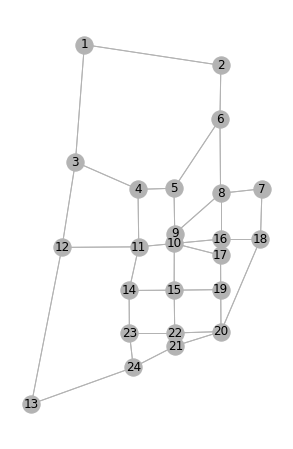

In [11]:
## Sioux Falls graph


model = bc.model.RandomModel(
    nodes_file='../instances/sioux-falls/nodes.csv',
    arcs_file='../instances/sioux-falls/arcs.csv',
)

fig, ax = plt.subplots(figsize=(5, 8))
bc.draw.draw(model, odpairs=False, ax=ax)

fig.savefig(get_resource_path('sioux_falls.png'), dpi=200, bbox_inches='tight', transparent=True)